# Plot QCL maps with corrections

## Imports

In [46]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import os
from glob import glob
import re
import pathlib

import os, sys
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

import pySNOM
from pySNOM import readers
from pySNOM import images
from pySNOM.spectra import NeaSpectrum

### Read image

We read the images using the 'ImageStackReader' which assumes the folder structure created by the Attocube NeaSCOPE microscopes. We read both O3A,O3P and M1A images. M1A images are used to calculate the image drifts. Since the images values only depend on the topography, and the amplitude is kept stable during the measurements, these images suit the drift calculation

In [61]:
measfolder = r"data\ImageStack"

r = readers.ImageStackReader(folder=measfolder)

channelstring_A = " O3A raw"
channelstring_P = " O3P raw"

optical_images_O3A, _ = r.read(channelstring_A)
optical_images_O3P, _ = r.read(channelstring_P)
tracking_images, wn = r.read(" M1A raw")

print(f"{np.shape(optical_images_O3A)[0]} images were loaded. Image size: {np.shape(optical_images_O3A)[1]} x {np.shape(optical_images_O3A)[2]} pixels")

47 images were loaded. Image size: 117 x 300 pixels


## Drift correction

In [48]:
aligner = images.AlignImageStack()
shifts, crossrect = aligner.calculate(tracking_images)

tracking_stack = aligner.transform(tracking_images,shifts,crossrect)
stack_O3A = aligner.transform(optical_images_O3A,shifts,crossrect)
stack_O3P = aligner.transform(optical_images_O3P,shifts,crossrect)

print(f"Size of the final images: {np.shape(stack_O3A[0])[0]} x {np.shape(stack_O3A[0])[1]} pixels")

Size of the final images: 88 x 291 pixels


## Plot the drifts for inspection

Text(0, 0.5, 'Drift in pixels')

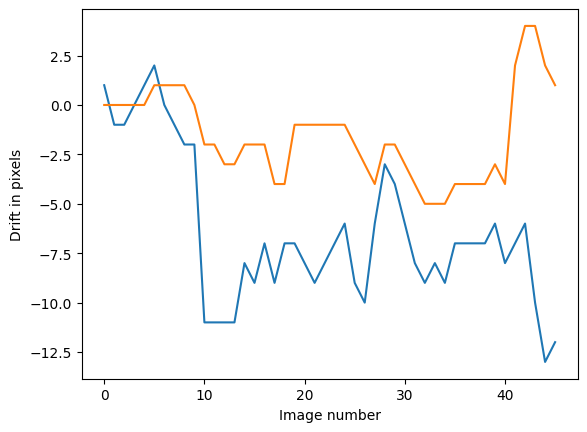

In [ ]:
plt.plot(shifts)
plt.xlabel("Image number")
plt.ylabel(f'Drift in pixels')

## Correct each image

We apply a basic median based line levelling to each image. Phase images are also corrected using an offresonant image (1600 cm-1) against negative phase artifacts.

In [50]:
ll_amp = images.LineLevel(method='median', datatype=images.DataTypes.Amplitude)
ll_phase = images.LineLevel(method='median', datatype=images.DataTypes.Phase)

stack_O3A_corr = []
stack_O3P_corr = []

for i in range(len(stack_O3A)):
    stack_O3A_corr.append(ll_amp.transform(stack_O3A[i]))
    stack_O3P_corr.append(ll_phase.transform(stack_O3P[i]))

# # Selfreference is only for phase data to remove negative phase artifacts
selfref = images.SelfReference(referencedata=stack_O3P_corr[19], datatype=images.DataTypes.Phase)
stack_O3P_corr_ref = []
for im in stack_O3P_corr:
    stack_O3P_corr_ref.append(selfref.transform(im))

## Plotting an image

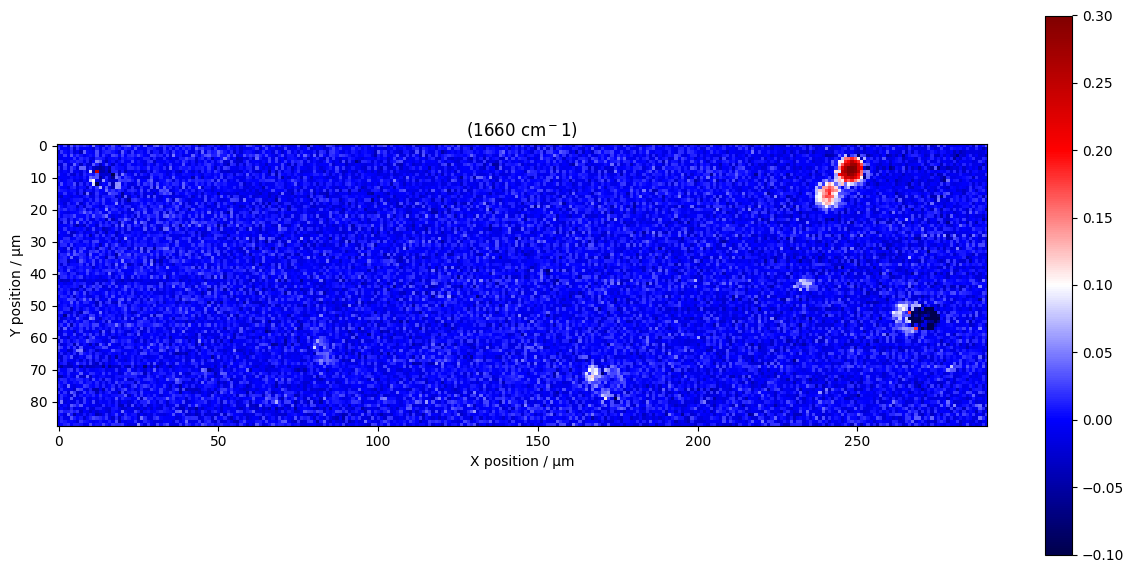

In [62]:
px = 1/plt.rcParams['figure.dpi']
fig= plt.figure(figsize=(1500*px, 700*px))

idx = 31
# plt.imshow(d, extent=[xmin, xmax, ymin, ymax], cmap=mpl.colormaps['seismic'], vmin=0.61, vmax=-0.4)
plt.imshow(stack_O3P_corr_ref[idx], cmap=mpl.colormaps['seismic'], vmin=0.3, vmax=0)
plt.xlabel('X position / μm')
plt.ylabel('Y position / μm')
plt.title(f'({round(wn[idx])} cm$^{-1}$)')
plt.colorbar()
plt.show()

## Create a spectral dataset

One can assembly a hyperspectral dataset from the list of corrected images. In the following, we turn the O2A image stack into a NeaSpectrum object and add the O3P as an additional channel.

In [57]:
# hyperdata, measparams = images.dict_from_imagestack(corrected_stack,channelstring,wn=wn)
hyperdataO2A, measparams = images.dict_from_imagestack(stack_O3A_corr,"O3A",wn=wn,is_interferogram=False)
hsi = NeaSpectrum(hyperdataO2A, measparams)
hyperdataO2P = images.flatten_stack(stack_O3P_corr_ref)
hsi.add_channel(hyperdataO2P,"O3P")

## Plot the spectra

We can access each spectra by indexing the desired location. The following plot shows the spectrum of the vesicle full of proteins.

Text(0, 0.5, 'O3P spectrum')

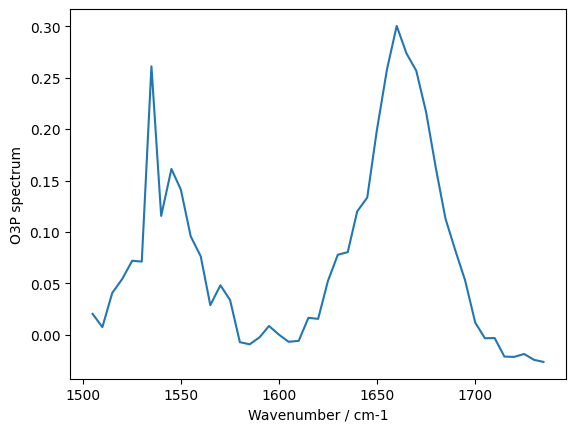

In [60]:
import matplotlib.pyplot as plt
plt.plot(hsi.data["Wavenumber"][0,0,:],hsi.data["O3P"][7,248,:])
plt.xlabel("Wavenumber / cm-1")
plt.ylabel(f'{"O3P"} spectrum')